# QBUS6830 Tutorial Lab 6: Forecasting and forecast accuracy
## Data
We use the data from the text by Tsay in Chapter 9, being monthly returns on IBM, HPQ, Intel, JP Morgan and Bank of America, from January, 1990 to December, 2008.

https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Autocorrelation_and_AR_Models/notebook.ipynb

https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Practical Time Series Analysis - Prediction with Statistics & Machine Learning - by Aileen Nielsen (Easy to find on https://library.sydney.edu.au/)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.multivariate.pca import PCA
from statsmodels.multivariate.factor import Factor
from scipy import stats
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA

In [7]:
data = pd.read_csv('Tsay_FM_data.txt', sep=" ")
data

,IBM,HPQ,INTC,JPM,BAC
0,4.670132,-5.715888,13.534180,-14.858700,-9.639196
1,6.344511,-3.419090,1.880900,-0.486582,6.565384
2,2.142973,6.138104,3.658937,-6.322525,-13.835790
3,2.673053,-4.756132,-5.539855,0.000000,-1.954476
4,10.617640,9.034880,20.009520,15.796310,2.853595
...,...,...,...,...,...
223,-4.596960,4.623548,3.628757,-5.410778,-5.498008
224,-3.997340,-1.287047,-19.969930,19.334560,13.497570
225,-22.955530,-18.891730,-15.560170,-11.492280,-37.023650
226,-12.433830,-8.161144,-13.976220,-26.459730,-39.701940


####  (a) Conduct a brief EDA on the five assets

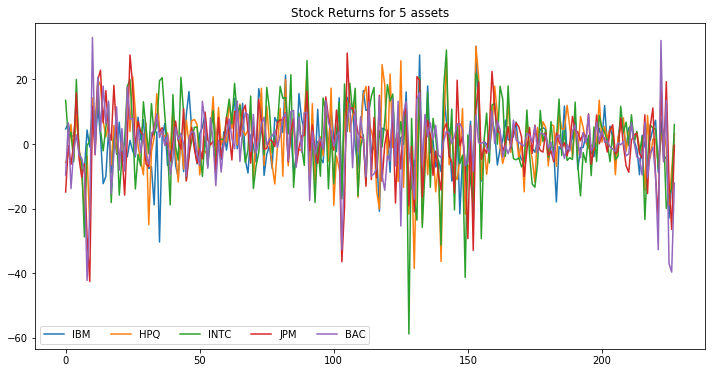

In [8]:
data.plot(figsize=(12, 6))
plt.title('Stock Returns for 5 assets')
plt.legend(loc='lower left', ncol=5)
plt.show()

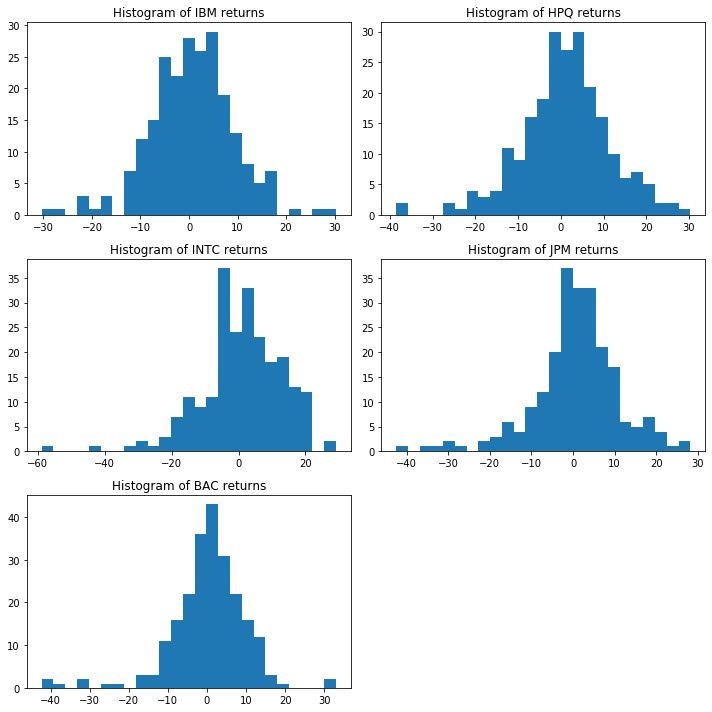

In [9]:
j = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0]])
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
for i in range(5):
    ax[j[i, 0], j[i, 1]].hist(data.iloc[:,i], bins=25)
    ax[j[i, 0], j[i, 1]].set_title('Histogram of {} returns'.format(data.columns[i]))
ax[2,1].axis('off')
plt.tight_layout()
plt.show()

In [10]:
descriptive = data.describe()
descriptive.loc['skew', :] = data.skew()
descriptive.loc['kurt', :] = kurtosis(data, fisher=False)
descriptive.round(3)

,IBM,HPQ,INTC,JPM,BAC
count,228.000,228.000,228.000,228.000,228.000
mean,0.700,0.986,1.196,0.824,0.410
std,8.639,10.593,12.104,10.297,9.583
min,-30.368,-38.550,-58.862,-42.583,-42.286
25%,-4.604,-4.796,-5.041,-3.527,-3.477
50%,1.007,1.256,1.716,0.988,0.645
75%,5.691,6.942,9.597,6.588,5.827
max,30.291,30.299,29.136,28.197,33.024
skew,-0.134,-0.359,-0.865,-0.731,-1.032
kurt,4.275,4.158,5.465,5.437,7.681


## Answer guide ##
From the time series plot, the 5 return series often move up and down in a similar fashion at the same time. The low volatility period leading up to 2008 is readily apparent, as is the increase in volatility marking the Global Financial Crisis period in 2008. The returns are clearly stationary in mean at least.

From the histograms, these assets are all quite peaked in the middle and fat-tailed: each has several apparently outlying return observations.

All return series have positive means and medians during this time period, from 0.4\% to 1.2\% average return per month; with standard deviation in returns all around 10\% a month. All have negative skew estimates, no doubt influenced by having a few quite large negative outlying returns, moreso than positive outliers; all series, except IBM, have minimum returns ($30-60$\%) much larger in magnitude than their associated maximum return (all $\approx 30$\%). From the histograms, most appear quite symmetric, except for INTC which shows a clear negative skew and long left tail. All are clearly more fat-tailed than a Gaussian (kurtosis = 3), with sample kurtosis > 3 in each case.

#### b) For each asset return series, use the following methods to provide horizon 1 forecasts for the last 24 months of returns in the sample:
1. Long-run mean for that asset
2. Mean of last 3 months for that asset
3. Mean of last 12 months for that asset
4. Mean of last 2 years for that asset
5. Naive
6. One adhoc or informal method that you make up or choose yourself
7. One ARMA model chosen for each series

In [19]:
data.head()

,IBM,HPQ,INTC,JPM,BAC
0,4.670132,-5.715888,13.534180,-14.858700,-9.639196
1,6.344511,-3.419090,1.880900,-0.486582,6.565384
2,2.142973,6.138104,3.658937,-6.322525,-13.835790
3,2.673053,-4.756132,-5.539855,0.000000,-1.954476
4,10.617640,9.034880,20.009520,15.796310,2.853595


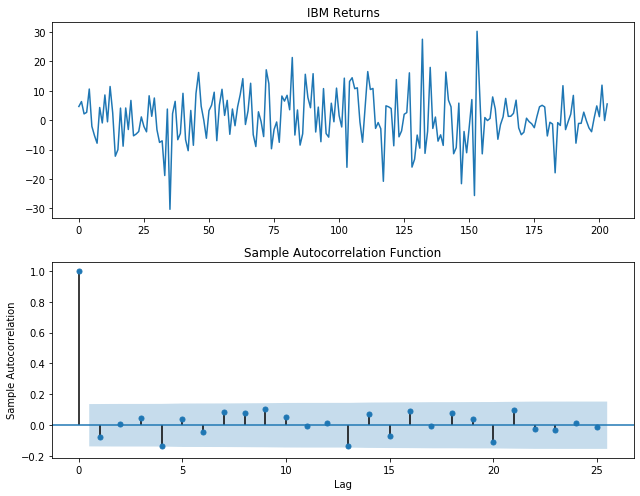

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))

ax[0].plot(data.iloc[:-24, 0])
ax[0].set_title('IBM Returns')

sm.graphics.tsa.plot_acf(data.iloc[:-24, 0], ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

## Answer guide ##
Note that there are methods to choose $p$ for an AR(p) model in general, but We don't have time to learn them in QBUS6830 at this point. I will thus not assess you on choosing a reasonable $p$ in an AR($p$) model in this part of the unit. We will learn a method to help choose $p$ later in the unit, based on information criteria. 

Below, I have arbitrarily chosen a range of values for $p$, and also an ARMA(1,1) model, across the 5 series, to illustrate any differences and similarities in forecast accuracy from these models. Basically, each ACF shows there are some significant autocorrelations in each series (you also know to use the LB test for that), which is partly why I ask you to choose an AR or ARMA model for each.

In [27]:
# model labelled f6 is chosen by me as the average return across all assets over the previous 6 months 
# (you should choose a different one)
# model f7 is chosen as AR(4) for IBM, based on the ACF. This is an arbitrary choice.

r = data
n_all = len(r)
n_fore = 24
n_wind = n_all - n_fore
f_ibm = np.empty((n_fore, 7))
i_col = 0  # IBM

for i in range(n_fore):
    r_wind = r.iloc[i:(i + n_wind), :]
    f_ibm[i, 0] = r_wind.iloc[:, i_col].mean()
    f_ibm[i, 1] = r_wind.iloc[-3:, i_col].mean()
    f_ibm[i, 2] = r_wind.iloc[-12:, i_col].mean()
    f_ibm[i, 3] = r_wind.iloc[-24:, i_col].mean()
    f_ibm[i, 4] = r_wind.iloc[-1:, i_col]
    f_ibm[i, 5] = r_wind.iloc[-6:, :].mean().mean()
    
    ar4_ibm = ARIMA(r_wind.iloc[:, i_col], order=(4, 0, 0)).fit()
    f_ibm[i, 6] = ar4_ibm.forecast(step=1)

In [89]:
i = 0
r_wind = r.iloc[i:(i + n_wind), :]
print(f"Window {i} : {i + n_wind} ")
print("-"*32)

print("Long run mean", r_wind.iloc[:, i_col].mean())
print("3 month mean", r_wind.iloc[-3:, i_col].mean())
print("12 month mean", r_wind.iloc[-12:, i_col].mean())
print("24 month mean", r_wind.iloc[-24:, i_col].mean())
print("Naive mean", r_wind.iloc[-1, i_col])
print("Portfolio of the assets", r_wind.iloc[-6:, :].mean().mean())

model = ARIMA(r_wind.iloc[:, i_col], order=(4, 0, 0)).fit()
print("AR(4)", model.forecast(step=1).values[0])

Window 0 : 204 
--------------------------------
Long run mean 1.046539835294118
3 month mean 0.2326593
12 month mean 1.5674150583333335
24 month mean 0.8850510791666667
Naive mean -0.8578692
Portfolio of the assets 2.8722907723333337
AR(4) 1.2158001590481184


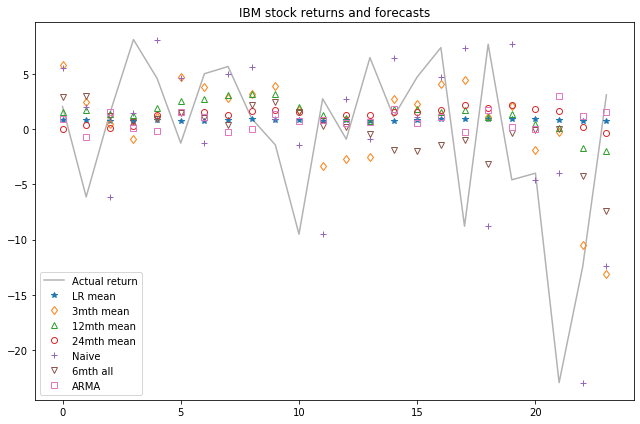

In [73]:
plt.figure(figsize=(9, 6))
plt.plot(r[-n_fore:].iloc[:, i_col].values, 'k', alpha=0.3, label='Actual return')
plt.plot(f_ibm[:, 0], '*', label='LR mean')
plt.plot(f_ibm[:, 1], 'd', mfc='none', label='3mth mean')
plt.plot(f_ibm[:, 2], '^', mfc='none', label='12mth mean')
plt.plot(f_ibm[:, 3], 'o', mfc='none', label='24mth mean')
plt.plot(f_ibm[:, 4], '+', label='Naive')
plt.plot(f_ibm[:, 5], 'v', mfc='none', label='6mth all')
plt.plot(f_ibm[:, 6], 's', mfc='none', label='ARMA')
plt.title('IBM stock returns and forecasts')
plt.legend()
plt.tight_layout()
plt.show()

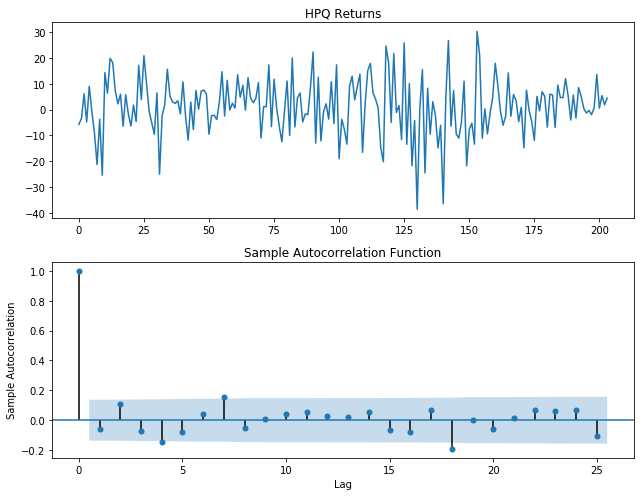

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))

ax[0].plot(data.iloc[:-24, 1])
ax[0].set_title('HPQ Returns')

sm.graphics.tsa.plot_acf(data.iloc[:-24, 1], ax=ax[1], lags=25, alpha=0.05)

ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')

plt.tight_layout()
plt.show()

In [77]:
# I choose f7 as AR(7) for HPQ, from ACF. This is an arbitrary choice on my part

f_hpq = np.empty((n_fore, 7))
i_col = 1  # HPQ
for i in range(n_fore):
    r_wind = r.iloc[i:(i + n_wind), :]
    f_hpq[i, 0] = r_wind.iloc[:, i_col].mean()
    f_hpq[i, 1] = r_wind.iloc[-3:, i_col].mean()
    f_hpq[i, 2] = r_wind.iloc[-12:, i_col].mean()
    f_hpq[i, 3] = r_wind.iloc[-24:, i_col].mean()
    f_hpq[i, 4] = r_wind.iloc[-1:, i_col]
    f_hpq[i, 5] = r_wind.iloc[-6:, :].mean().mean()
    
    ar7_hpq = ARIMA(r_wind.iloc[:, i_col], order=(7, 0, 0)).fit()
    f_hpq[i, 6] = ar7_hpq.forecast(step=1)

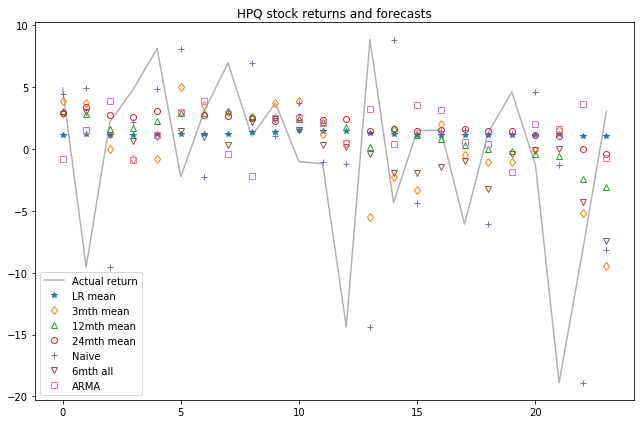

In [78]:
plt.figure(figsize=(9, 6))
plt.plot(r[-n_fore:].iloc[:, i_col].values, 'k', alpha=0.3, label='Actual return')
plt.plot(f_hpq[:, 0], '*', label='LR mean')
plt.plot(f_hpq[:, 1], 'd', mfc='none', label='3mth mean')
plt.plot(f_hpq[:, 2], '^', mfc='none', label='12mth mean')
plt.plot(f_hpq[:, 3], 'o', mfc='none', label='24mth mean')
plt.plot(f_hpq[:, 4], '+', label='Naive')
plt.plot(f_hpq[:, 5], 'v', mfc='none', label='6mth all')
plt.plot(f_hpq[:, 6], 's', mfc='none', label='ARMA')
plt.title('HPQ stock returns and forecasts')
plt.legend()
plt.tight_layout()
plt.show()

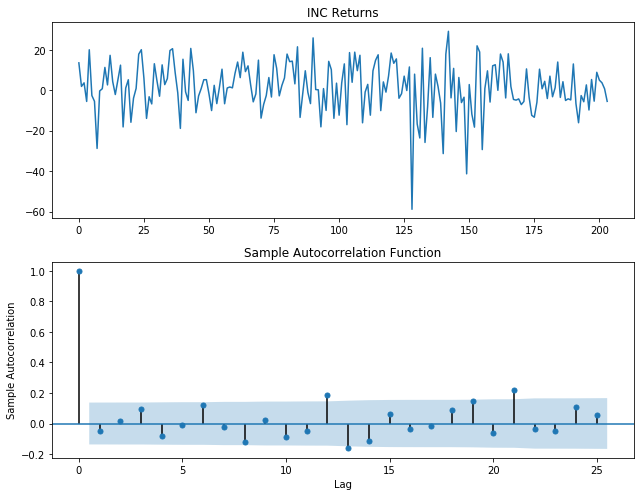

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
ax[0].plot(data.iloc[:-24, 2])
ax[0].set_title('INC Returns')
sm.graphics.tsa.plot_acf(data.iloc[:-24, 2], ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [80]:
# I choose f7 as ARMA(1,1) for INC. ARMA(1,1) can be chosen whenever the ACF dies down reasonably quickly
f_inc = np.empty((n_fore, 7))
i_col = 2  # INC
for i in range(n_fore):
    r_wind = r.iloc[i:(i + n_wind), :]
    f_inc[i, 0] = r_wind.iloc[:, i_col].mean()
    f_inc[i, 1] = r_wind.iloc[-3:, i_col].mean()
    f_inc[i, 2] = r_wind.iloc[-12:, i_col].mean()
    f_inc[i, 3] = r_wind.iloc[-24:, i_col].mean()
    f_inc[i, 4] = r_wind.iloc[-1:, i_col]
    f_inc[i, 5] = r_wind.iloc[-6:, :].mean().mean()
    
    # order = (AR, I, MA)
    arma11_inc = ARIMA(r_wind.iloc[:, i_col], order=(1, 0, 1)).fit()
    f_inc[i, 6] = arma11_inc.forecast(step=1)

/Users/jameschok/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jameschok/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


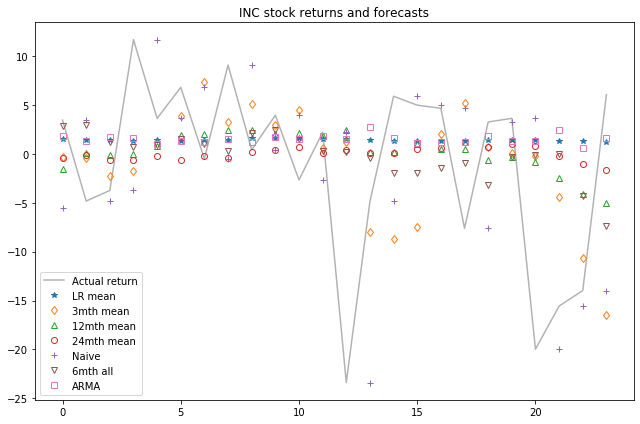

In [81]:
plt.figure(figsize=(9, 6))
plt.plot(r[-n_fore:].iloc[:, i_col].values, 'k', alpha=0.3, label='Actual return')
plt.plot(f_inc[:, 0], '*', label='LR mean')
plt.plot(f_inc[:, 1], 'd', mfc='none', label='3mth mean')
plt.plot(f_inc[:, 2], '^', mfc='none', label='12mth mean')
plt.plot(f_inc[:, 3], 'o', mfc='none', label='24mth mean')
plt.plot(f_inc[:, 4], '+', label='Naive')
plt.plot(f_inc[:, 5], 'v', mfc='none', label='6mth all')
plt.plot(f_inc[:, 6], 's', mfc='none', label='ARMA')
plt.title('INC stock returns and forecasts')
plt.legend()
plt.tight_layout()
plt.show()

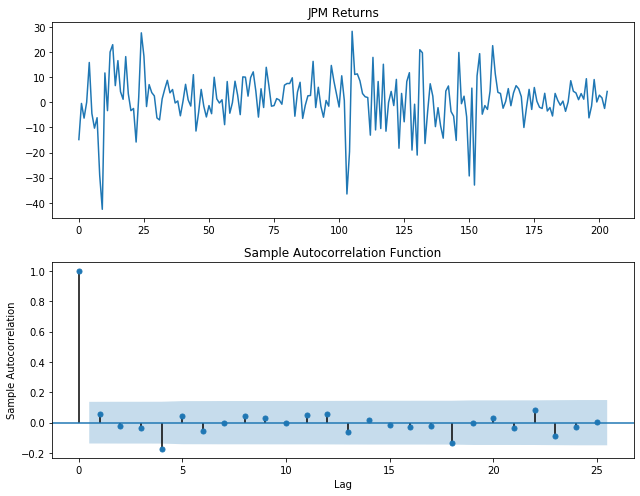

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
ax[0].plot(data.iloc[:-24, 3])
ax[0].set_title('JPM Returns')
sm.graphics.tsa.plot_acf(data.iloc[:-24, 3], ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [84]:
# f7 is AR(4) for JPM
f_jpm = np.empty((n_fore, 7))
i_col = 3  # JPM
for i in range(n_fore):
    r_wind = r.iloc[i:(i + n_wind), :]
    f_jpm[i, 0] = r_wind.iloc[:, i_col].mean()
    f_jpm[i, 1] = r_wind.iloc[-3:, i_col].mean()
    f_jpm[i, 2] = r_wind.iloc[-12:, i_col].mean()
    f_jpm[i, 3] = r_wind.iloc[-24:, i_col].mean()
    f_jpm[i, 4] = r_wind.iloc[-1:, i_col]
    f_jpm[i, 5] = r_wind.iloc[-6:, :].mean().mean()
    ar4_jpm = ARIMA(r_wind.iloc[:, i_col], order=(4, 0, 0)).fit()
    f_jpm[i, 6] = ar4_jpm.forecast(step=1)

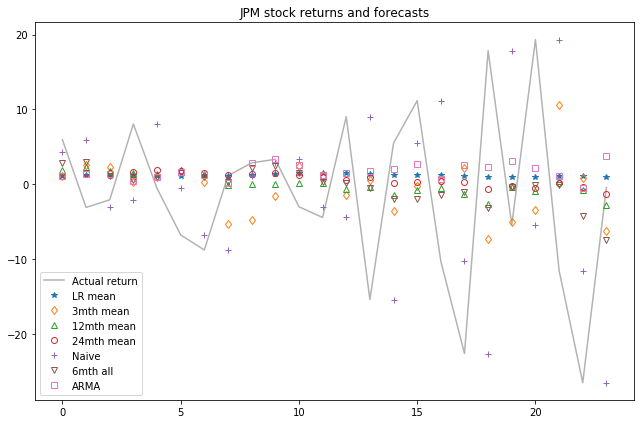

In [85]:
plt.figure(figsize=(9, 6))
plt.plot(r[-n_fore:].iloc[:, i_col].values, 'k', alpha=0.3, label='Actual return')
plt.plot(f_jpm[:, 0], '*', label='LR mean')
plt.plot(f_jpm[:, 1], 'd', mfc='none', label='3mth mean')
plt.plot(f_jpm[:, 2], '^', mfc='none', label='12mth mean')
plt.plot(f_jpm[:, 3], 'o', mfc='none', label='24mth mean')
plt.plot(f_jpm[:, 4], '+', label='Naive')
plt.plot(f_jpm[:, 5], 'v', mfc='none', label='6mth all')
plt.plot(f_jpm[:, 6], 's', mfc='none', label='ARMA')
plt.title('JPM stock returns and forecasts')
plt.legend()
plt.tight_layout()
plt.show()

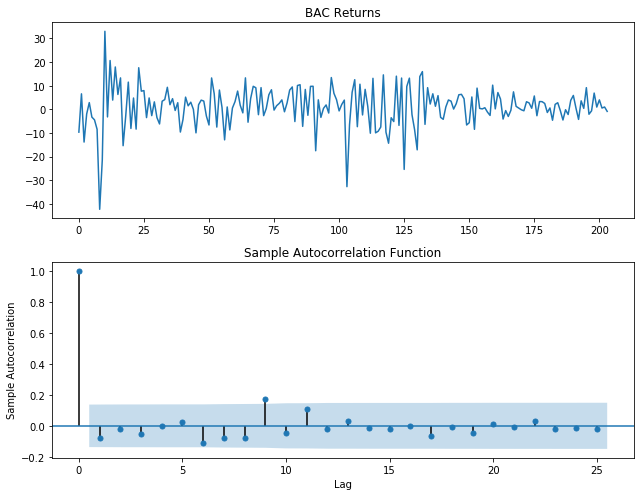

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
ax[0].plot(data.iloc[:-24, 4])
ax[0].set_title('BAC Returns')
sm.graphics.tsa.plot_acf(data.iloc[:-24, 4], ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [87]:
# f7 is chosen as AR(9) for BAC
f_bac = np.empty((n_fore, 7))
i_col = 4  # BAC
for i in range(n_fore):
    r_wind = r.iloc[i:(i + n_wind), :]
    f_bac[i, 0] = r_wind.iloc[:, i_col].mean()
    f_bac[i, 1] = r_wind.iloc[-3:, i_col].mean()
    f_bac[i, 2] = r_wind.iloc[-12:, i_col].mean()
    f_bac[i, 3] = r_wind.iloc[-24:, i_col].mean()
    f_bac[i, 4] = r_wind.iloc[-1:, i_col]
    f_bac[i, 5] = r_wind.iloc[-6:, :].mean().mean()
    ar9_bac = ARIMA(r_wind.iloc[:, i_col], order=(9, 0, 0)).fit()
    f_bac[i, 6] = ar9_bac.forecast(step=1)

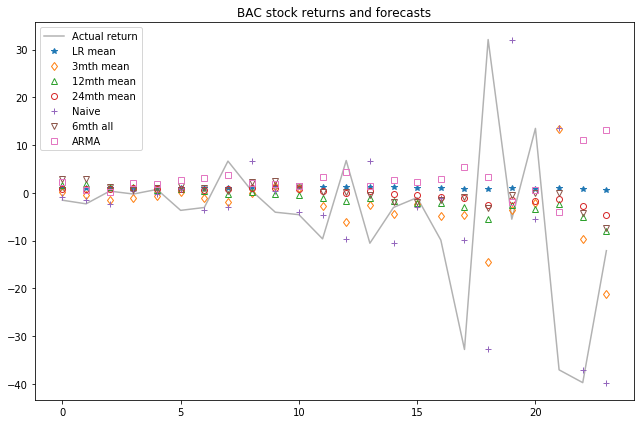

In [88]:
plt.figure(figsize=(9, 6))
plt.plot(r[-n_fore:].iloc[:, i_col].values, 'k', alpha=0.3, label='Actual return')
plt.plot(f_bac[:, 0], '*', label='LR mean')
plt.plot(f_bac[:, 1], 'd', mfc='none', label='3mth mean')
plt.plot(f_bac[:, 2], '^', mfc='none', label='12mth mean')
plt.plot(f_bac[:, 3], 'o', mfc='none', label='24mth mean')
plt.plot(f_bac[:, 4], '+', label='Naive')
plt.plot(f_bac[:, 5], 'v', mfc='none', label='6mth all')
plt.plot(f_bac[:, 6], 's', mfc='none', label='ARMA')
plt.title('BAC stock returns and forecasts')
plt.legend()
plt.tight_layout()
plt.show()

#### (c) Assess the accuracy of these forecasting methods using RMSE and MAD and M-Z regression.

In [92]:
def loss_func(y_obs, y_hat):
    rmse = np.sqrt(np.mean((y_hat - y_obs) ** 2))
    mad = np.mean(np.abs(y_hat - y_obs))
    return (rmse, mad)

In [102]:
# IBM
i_col = 0
r_fore = r.iloc[-n_fore:, i_col]
l = np.empty((2, 7))
for i in range(7):
    l[0, i], l[1, i] = loss_func(r_fore, f_ibm[:, i])
    
c_name = ['Mean', '3 Mth', '12 Mth', '24 Mth', 'Naive', 'Mn-Ovr-Ast', 'AR(4)']
tbl_ibm = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD'])
tbl_ibm

,Mean,3 Mth,12 Mth,24 Mth,Naive,Mn-Ovr-Ast,AR(4)
RMSE,7.4037,8.0989,7.2561,7.5729,9.1781,7.7593,7.6149
MAD,5.4269,6.1751,5.4123,5.6249,7.6163,6.1224,5.4473


In [103]:
# HPQ
i_col = 1
r_fore = r.iloc[-n_fore:, i_col]
l = np.empty((2, 7))
for i in range(7):
    l[0, i], l[1, i] = loss_func(r_fore, f_hpq[:, i])
c_name = ['Mean', '3 Mth', '12 Mth', '24 Mth', 'Naive', 'Mn-Ovr-Ast', 'AR(7)']
tbl_hpq = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD'])
tbl_hpq

,Mean,3 Mth,12 Mth,24 Mth,Naive,Mn-Ovr-Ast,AR(7)
RMSE,6.9568,7.9224,6.8128,7.0721,9.5984,7.0207,7.4026
MAD,4.9745,5.8034,4.9160,4.9121,7.7031,5.3174,5.7623


In [104]:
# INC
i_col = 2
r_fore = r.iloc[-n_fore:, i_col]
l = np.empty((2, 7))
for i in range(7):
    l[0, i], l[1, i] = loss_func(r_fore, f_inc[:, i])
c_name = ['Mean', '3 Mth', '12 Mth', '24 Mth', 'Naive', 'Mn-Ovr-Ast', 'ARMA(1,1)']
tbl_inc = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD'])
tbl_inc

,Mean,3 Mth,12 Mth,24 Mth,Naive,Mn-Ovr-Ast,"ARMA(1,1)"
RMSE,9.3333,10.4181,8.9583,9.2150,11.4107,9.3153,9.374
MAD,6.8075,7.9009,6.8789,7.0164,8.9456,7.3503,6.805


In [105]:
# JPM
i_col = 3
r_fore = r.iloc[-n_fore:, i_col]
l = np.empty((2, 7))
for i in range(7):
    l[0, i], l[1, i] = loss_func(r_fore, f_jpm[:, i])
c_name = ['Mean', '3 Mth', '12 Mth', '24 Mth', 'Naive', 'Mn-Ovr-Ast', 'AR(4)']
tbl_jpm = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD'])
tbl_jpm

,Mean,3 Mth,12 Mth,24 Mth,Naive,Mn-Ovr-Ast,AR(4)
RMSE,11.2844,13.2072,11.2778,11.2487,17.0078,11.0187,11.1681
MAD,8.7453,10.7233,8.9909,8.7634,13.2058,8.8261,8.7138


In [106]:
# BAC
i_col = 4
r_fore = r.iloc[-n_fore:, i_col]
l = np.empty((2, 7))
for i in range(7):
    l[0, i], l[1, i] = loss_func(r_fore, f_bac[:, i])
c_name = ['Mean', '3 Mth', '12 Mth', '24 Mth', 'Naive', 'Mn-Ovr-Ast', 'AR(9)']
tbl_bac = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD'])
tbl_bac

,Mean,3 Mth,12 Mth,24 Mth,Naive,Mn-Ovr-Ast,AR(9)
RMSE,15.9958,17.3274,15.0590,15.3205,21.1524,15.3365,17.6487
MAD,10.6433,10.4629,9.5948,9.9289,13.0770,10.0568,11.6924


In [108]:
# combine BAC forecasts into a dataframe
dff_bac = pd.DataFrame({
    'r_fore': r_fore,
    'f_bac_mn': f_bac[:, 0],
    'f_bac_3m': f_bac[:, 1],
    'f_bac_12m': f_bac[:, 2],
    'f_bac_24m': f_bac[:, 3],
    'f_bac_naive': f_bac[:, 4],
    'f_bac_mna': f_bac[:, 5],
    'f_bac_ar9': f_bac[:, 6]})
dff_bac

,r_fore,f_bac_mn,f_bac_3m,f_bac_12m,f_bac_24m,f_bac_naive,f_bac_mna,f_bac_ar9
204,-1.528726,1.046540,0.232659,1.567415,0.885051,-0.857869,2.872291,2.213644
205,-2.289203,1.086297,-0.463062,1.794140,0.876695,-1.528726,2.968691,0.697656
206,0.373103,1.042892,-1.558599,1.303605,0.756229,-2.289203,1.160494,0.213770
207,-0.235477,1.112544,-1.148275,1.300235,0.963694,0.373103,0.647348,2.081556
208,0.724271,1.120970,-0.717192,0.515358,0.866004,-0.235477,0.951430,1.827352
209,-3.654988,1.110532,0.287299,0.747752,0.779420,0.724271,1.470369,2.709067
210,-3.052931,1.108689,-1.055398,0.494980,0.650583,-3.654988,0.968936,3.103290
211,6.648693,1.115439,-1.994549,-0.333449,0.711167,-3.052931,0.333307,3.701421
212,0.452773,1.189350,-0.019742,0.140140,0.994889,6.648693,2.178081,1.995981
213,-4.039084,1.398853,1.349512,-0.155376,1.104796,0.452773,2.431180,1.943863


In [110]:
# BAC Mincer-Zarnawitz regressions
import statsmodels.formula.api as smf

mz_bac_mn = smf.ols('r_fore ~ f_bac_mn', dff_bac).fit()
mz_bac_3m = smf.ols('r_fore ~ f_bac_3m', dff_bac).fit()
mz_bac_12m = smf.ols('r_fore ~ f_bac_12m', dff_bac).fit()
mz_bac_24m = smf.ols('r_fore ~ f_bac_24m', dff_bac).fit()
mz_bac_naive = smf.ols('r_fore ~ f_bac_naive', dff_bac).fit()
mz_bac_mna = smf.ols('r_fore ~ f_bac_mna', dff_bac).fit()
mz_bac_ar9 = smf.ols('r_fore ~ f_bac_ar9', dff_bac).fit()

mz_bac_ar9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 r_fore   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8387
Date:                Fri, 17 Sep 2021   Prob (F-statistic):              0.370
Time:                        11:52:18   Log-Likelihood:                -98.325
No. Observations:                  24   AIC:                             200.6
Df Residuals:                      22   BIC:                             203.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6884      3.997     -0.673      0.508     -10.979       5.602
f_bac_ar9     -0.8310      0.907     -0.916      0.370      -2.713       1.051
==============================================================================
Omnibus:                        5.241   Durbin-Watson:                   2.287
Prob(Omnibus):                  0.073   Jarque-Bera (JB):                3.935
Skew:                          -0.406   Prob(JB):                        0.140
Kurtosis:                       4.810   Cond. No.                         5.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
dff_bac.head()

,r_fore,f_bac_mn,f_bac_3m,f_bac_12m,f_bac_24m,f_bac_naive,f_bac_mna,f_bac_ar9
204,-1.528726,1.046540,0.232659,1.567415,0.885051,-0.857869,2.872291,2.213644
205,-2.289203,1.086297,-0.463062,1.794140,0.876695,-1.528726,2.968691,0.697656
206,0.373103,1.042892,-1.558599,1.303605,0.756229,-2.289203,1.160494,0.213770
207,-0.235477,1.112544,-1.148275,1.300235,0.963694,0.373103,0.647348,2.081556
208,0.724271,1.120970,-0.717192,0.515358,0.866004,-0.235477,0.951430,1.827352


In [113]:
# BAC F test for alpha=0, beta=1 from MZ regression

wald_mn = mz_bac_mn.wald_test('(Intercept = 0, f_bac_mn = 1)')
wald_3m = mz_bac_3m.wald_test('(Intercept = 0, f_bac_3m = 1)')
wald_12m = mz_bac_12m.wald_test('(Intercept = 0, f_bac_12m = 1)')
wald_24m = mz_bac_24m.wald_test('(Intercept = 0, f_bac_24m = 1)')
wald_naive = mz_bac_naive.wald_test('(Intercept = 0, f_bac_naive = 1)')
wald_mna = mz_bac_mna.wald_test('(Intercept = 0, f_bac_mna = 1)')
wald_ar9 = mz_bac_ar9.wald_test('(Intercept = 0, f_bac_ar9 = 1)')

In [114]:
# BAC MZ R^2
mz_bac_r2 = pd.Series([
    mz_bac_mn.rsquared,
    mz_bac_3m.rsquared,
    mz_bac_12m.rsquared,
    mz_bac_24m.rsquared,
    mz_bac_naive.rsquared,
    mz_bac_mna.rsquared,
    mz_bac_ar9.rsquared], index=dff_bac.columns[1:])
#mz_bac_r2

In [115]:
# MZ F-stat
mz_f = pd.Series([
    wald_mn.fvalue[0][0],
    wald_3m.fvalue[0][0],
    wald_12m.fvalue[0][0],
    wald_24m.fvalue[0][0],
    wald_naive.fvalue[0][0],
    wald_mna.fvalue[0][0],
    wald_ar9.fvalue[0][0]], index=dff_bac.columns[1:])
#mz_f

In [116]:
# MZ p-value
mz_p = pd.Series([
    wald_mn.pvalue,
    wald_3m.pvalue,
    wald_12m.pvalue,
    wald_24m.pvalue,
    wald_naive.pvalue,
    wald_mna.pvalue,
    wald_ar9.pvalue], index=dff_bac.columns[1:])
#mz_p

In [117]:
# BAC MZ parameters
mz_bac_par = pd.DataFrame([
    mz_bac_mn.params.values,
    mz_bac_3m.params.values,
    mz_bac_12m.params.values,
    mz_bac_24m.params.values,
    mz_bac_naive.params.values,
    mz_bac_mna.params.values,
    mz_bac_ar9.params.values], index=dff_bac.columns[1:], columns=['alpha', 'beta'])
mz_bac_par

,alpha,beta
f_bac_mn,-17.772494,11.959431
f_bac_3m,-6.536401,-0.535555
f_bac_12m,-3.548599,1.067086
f_bac_24m,-4.360340,2.322438
f_bac_naive,-5.089122,-0.020515
f_bac_mna,-4.785424,1.242599
f_bac_ar9,-2.688379,-0.831038


In [118]:
# BAC
i_col = 4
r_fore = r.iloc[-n_fore:, i_col]
l = np.empty((5, 7))
for i in range(7):
    l[0, i], l[1, i] = loss_func(r_fore, f_bac[:, i])
    l[2, i] = mz_bac_r2[i]
    l[3, i] = mz_f[i]
    l[4, i] = mz_p[i]
c_name = ['Mean', '3 Mth', '12 Mth', '24 Mth', 'Naive', 'Mn-Ovr-Ast', 'AR(9)']
tbl_bac = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD', 'MZ R-sq', 'MZ F', 'MZ pval'])
tbl_bac

,Mean,3 Mth,12 Mth,24 Mth,Naive,Mn-Ovr-Ast,AR(9)
RMSE,15.9958,17.3274,15.0590,15.3205,21.1524,15.3365,17.6487
MAD,10.6433,10.4629,9.5948,9.9289,13.0770,10.0568,11.6924
MZ R-sq,0.0237,0.0477,0.0292,0.0505,0.0004,0.0379,0.0367
MZ F,2.1084,4.7702,0.6838,1.3645,11.3883,1.2276,5.1733
MZ pval,0.1453,0.0190,0.5151,0.2763,0.0004,0.3123,0.0144


## Answer guide ##
The model that minimizes the RMSE and MAD forecast accuracy measures for BAC is the 12 month average, this model also cannot be rejected by the F test that $\alpha=0, \beta=1$. This seems like the most accurate forecsat model. However, it is a very weak fit to the BAC forecast returns with $R^2$ of only 2.9\%. 

The model with the strongest fit has $R^2$ of 4.8\%; this is a pretty weak forecast model. And for that model we can reject the hypothesis $\alpha=0, \beta=1$ with p-value $\approx 0.02$. 

Basically, none of the forecast models fit well at all: all are pretty weak fits to the forecast data and none really follow the forecast data much at all. In saying that, the Mean, 12 month, 24 month mean and Mean over assets models are relatively the best of a bad bunch and the naive model is the worst performing overall. The AR(9) model is probably the 2nd worst performing model, over all measures.

In [35]:
# IBM
i_col = 0
r_fore = r.iloc[-n_fore:, i_col]

# combine IBM forecasts into a dataframe
dff_ibm = pd.DataFrame({
    'r_fore': r_fore,
    'f_ibm_mn': f_ibm[:, 0],
    'f_ibm_3m': f_ibm[:, 1],
    'f_ibm_12m': f_ibm[:, 2],
    'f_ibm_24m': f_ibm[:, 3],
    'f_ibm_naive': f_ibm[:, 4],
    'f_ibm_mna': f_ibm[:, 5],
    'f_ibm_ar4': f_ibm[:, 6]})
dff_ibm

,r_fore,f_ibm_mn,f_ibm_3m,f_ibm_12m,f_ibm_24m,f_ibm_naive,f_ibm_mna,f_ibm_ar4
204,2.037795,0.837628,5.784245,1.502458,0.032883,5.533726,2.872291,0.877994
205,-6.145740,0.824725,2.484117,1.764019,0.341802,2.037795,2.968691,-0.750805
206,1.410308,0.763498,0.475260,1.340493,0.115272,-6.145740,1.160494,1.539796
207,8.097243,0.759907,-0.899212,1.229579,0.228396,1.410308,0.647348,0.071625
208,4.579903,0.786496,1.120604,1.917493,1.312890,8.097243,0.951430,-0.151105
209,-1.274487,0.756899,4.695818,2.518599,1.538228,4.579903,1.470369,1.510266
210,5.003320,0.760972,3.800886,2.739981,1.560252,-1.274487,0.968936,1.129554
211,5.657124,0.811191,2.769579,3.093168,1.278709,5.003320,0.333307,-0.299398
212,0.946705,0.877388,3.128652,3.159090,1.648352,5.657124,2.178081,-0.021281
213,-1.436367,0.860840,3.869050,3.138742,1.708525,0.946705,2.431180,1.337533


In [36]:
# IBM Mincer-Zarnawitz regressions
import statsmodels.formula.api as smf

mz_ibm_mn = smf.ols('r_fore ~ f_ibm_mn', dff_ibm).fit()
mz_ibm_3m = smf.ols('r_fore ~ f_ibm_3m', dff_ibm).fit()
mz_ibm_12m = smf.ols('r_fore ~ f_ibm_12m', dff_ibm).fit()
mz_ibm_24m = smf.ols('r_fore ~ f_ibm_24m', dff_ibm).fit()
mz_ibm_naive = smf.ols('r_fore ~ f_ibm_naive', dff_ibm).fit()
mz_ibm_mna = smf.ols('r_fore ~ f_ibm_mna', dff_ibm).fit()
mz_ibm_ar4 = smf.ols('r_fore ~ f_ibm_ar4', dff_ibm).fit()

# ibm F test for alpha=0, beta=1 from MZ regression

wald_mn = mz_ibm_mn.wald_test('(Intercept = 0, f_ibm_mn = 1)')
wald_3m = mz_ibm_3m.wald_test('(Intercept = 0, f_ibm_3m = 1)')
wald_12m = mz_ibm_12m.wald_test('(Intercept = 0, f_ibm_12m = 1)')
wald_24m = mz_ibm_24m.wald_test('(Intercept = 0, f_ibm_24m = 1)')
wald_naive = mz_ibm_naive.wald_test('(Intercept = 0, f_ibm_naive = 1)')
wald_mna = mz_ibm_mna.wald_test('(Intercept = 0, f_ibm_mna = 1)')
wald_ar4 = mz_ibm_ar4.wald_test('(Intercept = 0, f_ibm_ar4 = 1)')

# ibm MZ R^2
mz_ibm_r2 = pd.Series([
    mz_ibm_mn.rsquared,
    mz_ibm_3m.rsquared,
    mz_ibm_12m.rsquared,
    mz_ibm_24m.rsquared,
    mz_ibm_naive.rsquared,
    mz_ibm_mna.rsquared,
    mz_ibm_ar4.rsquared], index=dff_ibm.columns[1:])
#mz_ibm_r2

# MZ F-stat
mz_f = pd.Series([
    wald_mn.fvalue[0][0],
    wald_3m.fvalue[0][0],
    wald_12m.fvalue[0][0],
    wald_24m.fvalue[0][0],
    wald_naive.fvalue[0][0],
    wald_mna.fvalue[0][0],
    wald_ar4.fvalue[0][0]], index=dff_ibm.columns[1:])
#mz_f

# MZ p-value
mz_p = pd.Series([
    wald_mn.pvalue,
    wald_3m.pvalue,
    wald_12m.pvalue,
    wald_24m.pvalue,
    wald_naive.pvalue,
    wald_mna.pvalue,
    wald_ar4.pvalue], index=dff_ibm.columns[1:])
#mz_p

# ibm MZ parameters
mz_ibm_par = pd.DataFrame([
    mz_ibm_mn.params.values,
    mz_ibm_3m.params.values,
    mz_ibm_12m.params.values,
    mz_ibm_24m.params.values,
    mz_ibm_naive.params.values,
    mz_ibm_mna.params.values,
    mz_ibm_ar4.params.values], index=dff_ibm.columns[1:], columns=['alpha', 'beta'])
mz_ibm_par

,alpha,beta
f_ibm_mn,29.582741,-36.803814
f_ibm_3m,-0.558843,0.201162
f_ibm_12m,-2.827130,1.687589
f_ibm_24m,0.881208,-1.117235
f_ibm_naive,-0.389583,0.209291
f_ibm_mna,-0.494378,-0.168816
f_ibm_ar4,1.101119,-2.012698


In [37]:
# IBM
i_col = 0
r_fore = r.iloc[-n_fore:, i_col]
l = np.empty((5, 7))
for i in range(7):
    l[0, i], l[1, i] = loss_func(r_fore, f_ibm[:, i])
    l[2, i] = mz_ibm_r2[i]
    l[3, i] = mz_f[i]
    l[4, i] = mz_p[i]
c_name = ['Mean', '3 Mth', '12 Mth', '24 Mth', 'Naive', 'Mn-Ovr-Ast', 'AR(4)']
tbl_ibm = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD', 'MZ R-sq', 'MZ F', 'MZ pval'])
tbl_ibm

,Mean,3 Mth,12 Mth,24 Mth,Naive,Mn-Ovr-Ast,AR(4)
RMSE,7.4037,8.0989,7.2561,7.5729,9.1781,7.7593,7.6149
MAD,5.4269,6.1751,5.4123,5.6249,7.6163,6.1224,5.4473
MZ R-sq,0.0910,0.0151,0.0846,0.0120,0.0446,0.0029,0.0538
MZ F,1.5383,2.8473,0.9588,1.0690,7.3317,1.5545,1.7418
MZ pval,0.2370,0.0795,0.3988,0.3605,0.0036,0.2336,0.1985


## Answer guide ##
The model that minimizes the RMSE and MAD forecast accuracy measures for IBM is again the 12 month average, this model also cannot be rejected by the F test that $\alpha=0, \beta=1$. This seems like the most accurate forecsat model. However, it is a very weak fit to the BAC forecast returns with $R^2$ of only 8.5\%. 

The model with the strongest fit has $R^2$ of 9.1\%; this is still pretty weak forecast model. And that for that model we can also not reject the hypothesis $\alpha=0, \beta=1$ with p-value $\approx 0.24$. 

Basically, none of the forecast models fit well at all: all are pretty weak fits to the forecast data and none really follow the forecast data much at all. In saying that, the Mean, 12 month, 24 month mean and Mean over assets models are relatively the best of a bad bunch and the naive model is the worst performing overall. The AR(4) is marginally better than the 3 month mean, but marginally worse than the better models.

I leave it to you to do the other 3 series; similar conclusions will result.

#### (d) As an experiment, find the returns that would have been made from investing under the following strategies:
1. Equally weighted across all five assets, long 24 month holding.
2. Invest in the single asset, long and for 1 month holding, based on the forecast that gave the highest predicted return in each month, across the five assets. I.e. invest in the asset that had the maximum predicted return in each month. (Repeat this for all 6 forecast methods).
3. Weight the assets proportionally to their predicted return magnitude, in each month.
4. Weight the assets inversely proportionally to their absolute predicted returns.

Conduct these strategies for the last 24 months in the sample and examine risk and return performance.

In [120]:
# Efficient Portfolio Theory

In [38]:
# Strategy 1
r_fore = r.iloc[-24:, :]
r_eq_wt = np.mean(r_fore, axis=1)
mn_eq_wt = np.mean(r_eq_wt)
sd_eq_wt = np.std(r_eq_wt, ddof=1)
print(mn_eq_wt)
print(sd_eq_wt)

-1.717014815
7.765496724640769


In [39]:
# Strategy 2
f_all = np.empty((n_fore, 7, 5))
f_all[:, :, 0] = f_ibm
f_all[:, :, 1] = f_hpq
f_all[:, :, 2] = f_inc
f_all[:, :, 3] = f_jpm
f_all[:, :, 4] = f_bac

r_max_ret = np.empty((n_fore, 7))
for i in range(7):
    i_max = np.argmax(f_all[:, i, :], axis=1)
    r_max_ret[:, i] = r_fore.values[range(n_fore), i_max]
mn_max_ret = np.mean(r_max_ret, axis=0)
sd_max_ret = np.std(r_max_ret, axis=0, ddof=1)
print(mn_max_ret)
print(sd_max_ret)

[-1.58340199 -3.77953721 -1.53288822 -0.78172742 -2.68408004 -0.46573986
 -2.1305653 ]
[ 9.58602991 11.44342208  9.09608065  8.1309997   7.43978188  7.43010446
 14.82399539]


In [40]:
# Strategy 3
r_prop_ret = np.empty((n_fore, 7))
w = np.empty((n_fore, 5))
for i in range(7):
    r_sum = np.sum(f_all[:, i, :], axis=1)
    w = f_all[:, i, :] / r_sum.reshape(-1, 1)
    r_prop_ret[:, i] = np.sum(r_fore.values * w, axis=1)
mn_prop_ret = np.mean(r_prop_ret, axis=0)
sd_prop_ret = np.std(r_prop_ret, axis=0, ddof=1)
print(mn_prop_ret)
print(sd_prop_ret)

[-1.73151324  2.14221144 -1.47993328 -5.85184405 -0.90642003 -1.71701481
 -2.04998317]
[ 7.4450131  12.31228458 39.85868111 16.83594263 20.1796955   7.76549672
  9.87979025]


In [41]:
# Strategy 4
r_invp_ret = np.empty((n_fore, 7))
w = np.empty((n_fore, 5))
for i in range(7):
    t1 = 1 / np.abs(f_all[:, i, :])
    t2 = np.sum(t1, axis=1)
    w = t1 / t2.reshape(-1, 1)
    r_invp_ret[:, i] = np.sum(r_fore.values * w, axis=1)

    mn_invp_ret = np.mean(r_invp_ret, axis=0)
sd_invp_ret = np.std(r_invp_ret, axis=0, ddof=1)

print(mn_invp_ret)
print(sd_invp_ret)

[-1.67819732 -2.75910676 -1.57385503 -0.63958724 -1.80116506 -1.71701481
 -1.78652111]
[8.15110127 8.10991238 7.1981073  6.9848986  7.11487746 7.76549672
 6.67770796]


## Answer guide ##
These are all simulated investing strategies. They all use only data available prior to investment and hence generate exactly the returns that could have been achieved in real investing using these approaches. 

Portfolios need to assign weights to the individual assets within them. There are many millions of ways to assign such weights. It is usually hard to beat the simplest weighting that applies equal weights (e.g. 1/5 when there are 5 assets) to each asset. The weights tell us how much each asset comprises of the portfolio, in terms of number of shares, and is also the respective contributions of each asset’s return to the portfolio return.

The weighted portfolio log-return at time $t$ is: $r_{p,t} = \sum_{i=1}^5 w_{i,t} r_{i,t}$
where $r_{i,t}$ is the log-return on series $i$ at time $t$ and we ensure $\sum_{i=1}^5 w_{i,t} = 1$ for each $t$. 

Equal weighting sets $w_{i,t} = \frac{1}{5} = 0.2$ for each $i,t$. 

Another method of weighting is to assign a weight of 1 to one asset and 0 to the other 4. But these weights can change over time if we re-balance the portfolio during the period. The combination of these is what I have employed in strategy 2; where the asset with the highest forecast return next month has a weight of 1 and the others get a weight of 0. Since there are 6 methods to predict what the next month’s return will be, I used them all and produced six variants of this strategy.

Strategy 3 sets weights as: $w_{i,t} = \frac{\hat{r}_{i,t}}{\sum_{i=1}^5 \hat{r}_{i,t}}$. This strategy allows for negative weights, i.e. selling short an asset. Here we invest in each asset by an amount related to how much money we are predicted to make for that asset. Again, there are 6 methods for forecasting returns and I employed them all. 

Strategy 4 sets weights as: $w_{i,t} = \frac{|\hat{r}_{i,t}|^{-1}}{\sum_{i=1}^5 |\hat{r}_{i,t}|^{-1}}$. This could be seen as a risk-conservative strategy, since it weights assets higher if their predicted returns are closer to 0. 

The equal weighted stategy achieved a return  of -1.7\% and a return standard deviation of 7.8\%.

The method and model achieving the highest returns is from strategy 3 and model 2 (3 month mean) at 2.1\%. Strategy 3 is the only method that tries to maximise the return of the portfolio. However, we also note that the standard deviation from this portfolio is comparatively high at 12.3\%.

The method and model achieving the lowest standard deviation is from strategy 4 and model 7, the AR or ARMA model, with standadard deviation (or risk level) 6.7\% but also having average return -1.8\%. 4 other models also achieved standard deviation under the equal weighted method under strategy 4. 

Clearly, strategy 3 is the highest risk, with many high standard deviations, which has also led to the highest reurn of 2.1/%, but also the lowest return of -5.9\%. The risk here is increased, whcih allows possibly large returns, but sadly these can be negative or positive. 

Strategy 4 can reduce the portfolio risk (standard deviation), but has average returns mainly similar to the equal weighted strategy.

Notice that the models that led to lower risk or higher return (3 month, AR/ARMA) were not those that were the most accurate at forecasting. 